In [1]:
from __future__ import division, print_function
import uproot4
import uproot
import numpy as np
import awkward as ak
import pandas as pd
import numba as nb
import scipy.constants
import uproot_methods.convert
import matplotlib.pyplot as plt
import mplhep as hep
import h5py
from math import *
import sys
import uproot_methods

In [2]:
PATH = '/eos/home-m/matheus/sample_signal/' # caminho onde se encontra as nTuplas
#PATH_PLOT = '/home/matheus/Documentos/4quadri_vertive/plots_signal' # caminho para salvar os plots
SM = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_0.0.root'
ANOMALO1 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_2e-5.root'
ANOMALO2 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_2e-6.root'
ANOMALO3 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_5e-6.root'
ANOMALO4 = 'pre_MiniAOD_FPMC_WW_13TeV_0.0_8e-6.root'
ANOMALO5 = 'pre_MiniAOD_FPMC_WW_13TeV_0.5e-6_0.0.root'
ANOMALO6 = 'pre_MiniAOD_FPMC_WW_13TeV_1.0e-6_0.0.root'
ANOMALO7 = 'pre_MiniAOD_FPMC_WW_13TeV_2.0e-6_0.0.root'
ANOMALO8 = 'pre_MiniAOD_FPMC_WW_13TeV_5.0e-6_0.0.root'

 Seção de choque para as amostras de SIGNAL do Monte Carlo 


In [3]:
cross_section_SM       = 40.41*0.17
cross_section_ANOMALO1 = 166.1*0.17 
cross_section_ANOMALO2 = 41.90*0.17
cross_section_ANOMALO3 = 48.75*0.17
cross_section_ANOMALO4 = 61.14*0.17
cross_section_ANOMALO5 = 41.58*0.17
cross_section_ANOMALO6 = 44.93*0.17
cross_section_ANOMALO7 = 58.18*0.17 
cross_section_ANOMALO8 = 150.3*0.17

número de eventos para as amostras de SIGNAL do Monte Carlo 

In [4]:
number_events_SM       = 35000
number_events_ANOMALO1 = 35000
number_events_ANOMALO2 = 35000
number_events_ANOMALO3 = 35000
number_events_ANOMALO4 = 35000
number_events_ANOMALO5 = 35000
number_events_ANOMALO6 = 35000
number_events_ANOMALO7 = 35000
number_events_ANOMALO8 = 35000

Luminosidade dos eventos de dados 


In [5]:
SingleMuon_Run2016B = 4.55
SingleMuon_Run2016C = 1.59
SingleMuon_Run2016G = 3.65
Luminosidade        = SingleMuon_Run2016B + SingleMuon_Run2016C + SingleMuon_Run2016G 

Normalizacao dos eventos de SIGNAL

In [6]:
norm_SM = ( cross_section_SM * Luminosidade ) / ( number_events_SM )
norm_ANOMALO1 = ( cross_section_ANOMALO1 * Luminosidade ) / ( number_events_ANOMALO1 )
norm_ANOMALO2 = ( cross_section_ANOMALO2 * Luminosidade ) / ( number_events_ANOMALO2 )
norm_ANOMALO3 = ( cross_section_ANOMALO3 * Luminosidade ) / ( number_events_ANOMALO3 )
norm_ANOMALO4 = ( cross_section_ANOMALO4 * Luminosidade ) / ( number_events_ANOMALO4 )
norm_ANOMALO5 = ( cross_section_ANOMALO5 * Luminosidade ) / ( number_events_ANOMALO5 )
norm_ANOMALO6 = ( cross_section_ANOMALO6 * Luminosidade ) / ( number_events_ANOMALO6 )
norm_ANOMALO7 = ( cross_section_ANOMALO7 * Luminosidade ) / ( number_events_ANOMALO7 )
norm_ANOMALO8 = ( cross_section_ANOMALO8 * Luminosidade ) / ( number_events_ANOMALO8 )

Criando uma função que ler as nTuplas com o uproot e retorna a tree. Se quiser ver todos os branchs, descomenta a parte em que está print(tree_.show())

In [7]:
def open_files( file ): # Funcao que ler e abre as trees das nTuplas
    #print( file )
    root_ = uproot.open( file ) # abertura dos arquivos 
    tree_ = root_[ "demo/Events" ] # trees das nTupla
    #print( tree_.show() ) # printar na tela todos os branches da nTupla
    return tree_

Abrindo cada tree dos arquivos correspondentes ao modelo padrão e dos acoplamentos anômalos

In [8]:
tree_SM       = open_files( PATH + SM )
tree_ANOMALO1 = open_files( PATH + ANOMALO1 )
tree_ANOMALO2 = open_files( PATH + ANOMALO2 )
tree_ANOMALO3 = open_files( PATH + ANOMALO3 )
tree_ANOMALO4 = open_files( PATH + ANOMALO4 )
tree_ANOMALO5 = open_files( PATH + ANOMALO5 )
tree_ANOMALO6 = open_files( PATH + ANOMALO6 )
tree_ANOMALO7 = open_files( PATH + ANOMALO7 )
tree_ANOMALO8 = open_files( PATH + ANOMALO8 )

A função abaixo ( get_branche ) vai retornar um array do branche escolhido, por exemplo muon_pt, jetAK8_pt, jetAK8_prunedMass e etc.

In [9]:
def get_branche( tree , array ): # Return the disered branch 
    branch = np.array( pd.DataFrame( tree.array( array ) )[0] )
    return branch

def get_PfFrom( tree , array ):
    branche = tree.array( array ) 
    return branche

A função almir, dedicado ao meu vizinho velho que vem beber café toda tarde comigo, calcula as principais variáveis, como a massa reconstruida do WW, o momento transverso (Pt) do W leptônico, e o DeltaPhi entre jatos/MET e W_leptônico/W_hadrônico. Para fazer tais calculos, eu utilizo o TLorentzVector atribuida ao Python, que está inserida no uproot_methods, biblioteca está que é importarda na primeira célula.
A massa reconstruida do WW é a mais difícil, pois precisa da componente z do momento do neutrino. As equações usadas são.

 $k = \dfrac{m_{\text{w}}^{2}}{2} + \mathbf{P}^{T}_{\mu} \cdot \mathbf{P}^{T}_{\nu}$

$ p_{\nu}^{z} = \dfrac{k \cdot p_{\mu}^{z}}{p_{\mu}^{T2}} \pm \sqrt{ \dfrac{k^{2} \cdot p_{\mu}^{z2}}{p_{\mu}^{T4} } - \dfrac{E^{2}_{\mu}E_{miss}^{T2}}{p_{\mu}^{T2}} - k }$

Temos que tomar cuidado com a raiz negativa, neste caso, como estou trabalhando com numpy_array, o resultado de uma raiz imaginária vai ser NaN, usando o numpy.nan_to_num(raiz_), ele substitui o valor NaN por 0 e com isso eu consigo a parte real da minha expressão

In [10]:
def almir( tree ): # Funcao que retorna um DataFrame que contem a massa invariante do WW, pt do par de le
    

    Mw = 80.379 # massa do boson W
    
    jetAK8_pt = get_branche( tree , 'jetAK8_pt')
    jetAK8_prunedMass = get_branche( tree , 'jetAK8_prunedMass')
    jetAK8_tau21 = get_branche(tree, 'jetAK8_tau21')
    jetAK8_eta = get_branche( tree , 'jetAK8_eta')
    jetAK8_px =  get_branche(tree,'jetAK8_px')
    jetAK8_py =  get_branche(tree,'jetAK8_py')
    jetAK8_pz =  get_branche(tree,'jetAK8_pz')
    jetAK8_E =  get_branche(tree,'jetAK8_E')

    #print(jetAK8_pt) 
    
    METPt  = get_branche(tree, 'METPt' )
    METPx  = get_branche(tree, 'METPx' )
    METPy  = get_branche(tree, 'METPy' )
    METphi = get_branche(tree, 'METphi')

    #print(METphi)

    muon_pt  = get_branche(tree, 'muon_pt')
    muon_eta = get_branche(tree, 'muon_eta')
    muon_phi = get_branche(tree, 'muon_phi')
    muon_px  = get_branche(tree,'muon_px')
    muon_py  = get_branche(tree,'muon_py')
    muon_pz  = get_branche(tree,'muon_pz')
    muon_E   = get_branche(tree,'muon_E') 
    
    
    k = ( ( Mw**2 ) / 2 + muon_px * METPx ) +  (muon_py * METPy ) 
    raiz_ = ( ( ( (k * muon_pz)**2) / (muon_pt**4)  - ( (muon_E * METPt)**2 - k) / muon_pt**2)**0.5 )    
    raiz = np.nan_to_num(raiz_) # Os valores de NaN, causados pela divisão por 0 ou pelo resultado de uma raiz imaginária, é substituida por NaN
    Pz_nu = ( ( k * muon_pz / (muon_pt**2 ) ) + raiz ) # coordenada z do momentum do neutrino reconstruido
    W_lep_energy = ( muon_E + (METPx**2 + METPy**2 + Pz_nu**2)**0.5) # Energia do par de léptons  


    # Usamos o TLorenctzVector do Python 
    TLV_lep = uproot_methods.TLorentzVectorArray(
              muon_px + METPx,
              muon_py + METPy,
              muon_pz + Pz_nu, 
              W_lep_energy) # 4-vector do par de lepton
            
    TLV_jet = uproot_methods.TLorentzVectorArray(
              jetAK8_px,
              jetAK8_py,
              jetAK8_pz,
              jetAK8_E )    
    
    W_mass = ( TLV_lep + TLV_jet ).mass # Massa invariante do WW
    W_lep_pt = ( TLV_lep ).pt # Pt do par de lepton
    
    dphi_jet_lep = TLV_lep.phi - TLV_jet.phi
    dphi_jet_lep = np.where( dphi_jet_lep >=  scipy.constants.pi, dphi_jet_lep - 2*scipy.constants.pi, dphi_jet_lep)
    dphi_jet_lep = np.where( dphi_jet_lep <  - scipy.constants.pi, dphi_jet_lep + 2*scipy.constants.pi, dphi_jet_lep) # delta phi entre o jato e o par de lepton
    dphi_jet_MET = METphi - TLV_jet.phi
    dphi_jet_MET = np.where( dphi_jet_MET >=  scipy.constants.pi, dphi_jet_MET - 2*scipy.constants.pi, dphi_jet_MET)
    dphi_jet_MET = np.where( dphi_jet_MET <  - scipy.constants.pi, dphi_jet_MET + 2*scipy.constants.pi, dphi_jet_MET) # delta phi entre o jato e o MET 
    


    '''
    ** numeração das colunas do numpy array ** ( para facilitar na hora de fazer os cortes )

    0  --> massa do WW
    1  --> Pt do W leptônico
    2  --> DeltaPhi entre W_hadrônico e W_leptônico
    3  --> DeltaPhi entre Jatos e o MET
    4  --> jetAK8_pt
    5  --> jetAK8_eta
    6  --> jetAK8_prunedMass
    7  --> jetAK8_tau21
    8  --> METPt
    9  --> muon_pt
    10 --> muon_eta
    11 --> ExtraTracks

    '''

    pfeta = get_PfFrom(tree, 'pfeta')
    pfphi = get_PfFrom(tree, 'pfphi') 
    pffromPV = pd.DataFrame(get_PfFrom(tree, 'pffromPV'))

    dR_muon = pd.DataFrame( ( ( ( pfeta - muon_eta )**2 + ( pfphi - muon_phi )**2 )**0.5) )
    dR_jet =  pd.DataFrame( ( ( (pfeta - TLV_jet.eta )**2 + ( pfphi - TLV_jet.phi )**2 )**0.5) )

    pfCands_sel1_ = pffromPV[ pffromPV == 3.0 ] 
                    
    pfCands_sel2_ = pfCands_sel1_[
                    dR_muon > 0.3 
                    ] 

    pfCands_sel3_ = pfCands_sel2_[
                    dR_jet > 0.8
                    ] 
                    
    ExtraTracks = np.array( (pfCands_sel3_.T).count() )

    #print('ExtraTracks --> \n', ExtraTracks,'\n')

    events_all = np.concatenate( ( W_mass.reshape(-1,1), W_lep_pt.reshape(-1,1), dphi_jet_lep.reshape(-1,1), 
    dphi_jet_MET.reshape(-1,1),jetAK8_pt.reshape(-1,1), jetAK8_eta.reshape(-1,1), jetAK8_prunedMass.reshape(-1,1), jetAK8_tau21.reshape(-1,1), 
    METPt.reshape(-1,1), muon_pt.reshape(-1,1), muon_eta.reshape(-1,1), ExtraTracks.reshape(-1,1) ) , axis = 1 ) # concatenando todos as variáveis

    events_all_cut = (events_all[:,4] >= 200) & (events_all[:,5] <= 2.4) & (events_all[:,8] >= 40)  & (events_all[:,9] >= 53)  & (events_all[:,10] <= 2.4)  # realizando os cortes nas variáveis
    
    array_numpy = events_all[events_all_cut]

    columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta','jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks']

    DataFrame = pd.DataFrame( array_numpy , columns = columns )

    return DataFrame


Agora uma função genérica que monta os histogramas.
Aqui vale uma observação --> eu usei 2 plots para cada variável (branche). Como estou com muita amostra de sinal ( 8 anômalos + 1 SM ), se fosse fazer em um apenas, estaria muito poluído, então resolvi separar em dois, mantendo o modelo padrão em cada, porém, um plot tem os valores anômalos de Alpha0 e o outro de AlphaC.

In [11]:
def plot(lista_1,lista_2,bins0,bins1,label0,label1,fontsize_leg,xmin,xmax,xlabel,ylabel,fontsize_xlabel,fontsize_ylabel,loc_leg,lista_norm1,lista_norm2):
    fig, axes = plt.subplots( 1, 2, figsize=(15,10) )
    axes[0].hist( lista_1, bins = bins0, stacked=False, histtype = 'step', label=label0, density = False, weights = lista_norm1, color = ['cyan', 'green', 'red', 'fuchsia','gold'] )
    axes[0].legend(loc=loc_leg, fontsize=fontsize_leg)
    axes[0].set_xlim(xmin,xmax)
    axes[0].set_ylabel(ylabel, fontsize = fontsize_ylabel)
    axes[0].set_yscale('log')
    axes[0] = hep.cms.label(llabel="Preliminary", rlabel="$9.792 fb^{-1}$", ax = axes[0])

    axes[1].hist( lista_2, bins = bins1, stacked=False, histtype = 'step', label=label1, density = False, weights = lista_norm2, color = ['cyan', 'green', 'red', 'fuchsia','gold'] )
    axes[1].legend(loc=loc_leg, fontsize=fontsize_leg)
    axes[1].set_xlim(xmin,xmax)
    axes[1].set_xlabel(xlabel,fontsize = fontsize_xlabel)
    axes[1].set_yscale('log')
    axes[1] = hep.cms.label(llabel="Preliminary", rlabel="$9.792 fb^{-1}$", ax = axes[1])    
    #plt.savefig(PATH_PLOT+'/{}.pdf'.format(name))
    plt.show()

In [12]:
columns = np.array(  ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
                      'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks'],dtype = 'S')

Os labels, 0 e 1 são as legendas que entraram na identificação dos histogramas

In [13]:
label_0 = [
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=0.0$ (SM)',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-5}$',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-6}$',
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=5 \times 10^{-6}$', 
r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$'
          ]

label_1 = [
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.0$ (SM)',  
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.5 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 1.0 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $',
r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $'
          ]    

Aqui eu aplico a função almir em cada acoplamento anômalo e no SM

In [14]:
DataFrame_SM       = almir(tree_SM)
DataFrame_ANOMALO1 = almir(tree_ANOMALO1)
DataFrame_ANOMALO2 = almir(tree_ANOMALO2)
DataFrame_ANOMALO3 = almir(tree_ANOMALO3)
DataFrame_ANOMALO4 = almir(tree_ANOMALO4)
DataFrame_ANOMALO5 = almir(tree_ANOMALO5)
DataFrame_ANOMALO6 = almir(tree_ANOMALO6)
DataFrame_ANOMALO7 = almir(tree_ANOMALO7)
DataFrame_ANOMALO8 = almir(tree_ANOMALO8)

/usr/local/bin/start_ipykernel.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/bin/start_ipykernel.py:57: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/bin/start_ipykernel.py:58: RuntimeWarning: invalid value encountered in less
/usr/local/bin/start_ipykernel.py:60: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/bin/start_ipykernel.py:61: RuntimeWarning: invalid value encountered in less
/usr/local/bin/start_ipykernel.py:108: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/bin/start_ipykernel.py:108: RuntimeWarning: invalid value encountered in less_equal


# DataFrame das variáveis do Modelo Padrão

In [15]:
with h5py.File('data_SM.h5','w') as f: # Salvar arquivos em .h5
    dset = f.create_dataset( 'dados', data=DataFrame_SM )
    dset_columns = f.create_dataset( 'columns', data=columns )
    
df = None
with h5py.File('data_SM.h5', 'r') as f: # Ler o arquivo .h5 e mostrar como DataFrame
    print ( list(f.keys()) )
    dset = f['dados']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns_ = list( dset_columns )
    print ( columns_ )
    columns_str = [ item.decode("utf-8") for item in columns_ ]
    print ( columns_str )
    df = pd.DataFrame( dset, columns=columns_str )
    print ( df )    

['columns', 'dados']
(970, 12)
[[ 6.37139148e+02  2.54429644e+02  3.06960867e+00 ...  1.92344498e+02
  -1.04174209e+00  1.00000000e+00]
 [ 6.46534168e+02  2.48650981e+02 -3.06525471e+00 ...  1.44149872e+02
  -5.14989734e-01  2.00000000e+00]
 [ 1.64908790e+03  3.19642972e+02  3.13291890e+00 ...  2.04319656e+02
   1.59466517e+00  0.00000000e+00]
 ...
 [ 4.32252511e+02  2.04477885e+02  3.08290295e+00 ...  1.41562729e+02
   1.03790641e+00  2.00000000e+00]
 [ 7.00413751e+02  3.35900732e+02 -3.13185342e+00 ...  2.33479279e+02
  -9.71292138e-01  0.00000000e+00]
 [ 6.40844956e+02  2.43864934e+02  3.01551658e+00 ...  7.89502563e+01
   1.47076988e+00  0.00000000e+00]]
(12,)
[b'Mww', b'Pt_W_lep', b'dPhi_Whad_Wlep', b'dPhi_jatos_MET', b'jetAK8_pt', b'jetAK8_eta', b'jetAK8_prunedMass', b'jetAK8_tau21', b'METPt', b'muon_pt', b'muon_eta', b'ExtraTracks']
['Mww', 'Pt_W_lep', 'dPhi_Whad_Wlep', 'dPhi_jatos_MET', 'jetAK8_pt', 'jetAK8_eta', 'jetAK8_prunedMass', 'jetAK8_tau21', 'METPt', 'muon_pt', 'muon_et

# DataFrame de um dos acoplamentos anômalos

In [16]:
DataFrame_ANOMALO1

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks
0,1464.912537,464.060132,3.124897,-3.119953,462.924162,-0.218007,13.116200,0.529439,376.916046,88.606506,1.686903,0.0
1,1126.157652,526.880950,-3.114235,2.829327,535.876462,0.600692,49.579361,0.323783,41.361801,488.076263,-0.036160,0.0
2,1355.680503,655.248793,-3.126095,3.082517,669.858980,0.480914,76.008347,0.437375,455.670807,203.693573,0.133551,0.0
3,1002.073114,477.793826,3.081743,3.064099,457.499916,-0.150724,68.873322,0.516303,45.144146,432.657440,0.515345,4.0
4,1701.789500,744.289726,-3.121886,-3.042725,740.555715,-0.469678,18.632336,0.744391,408.788422,338.329315,0.573012,1.0
5,1616.544883,564.328912,-3.135264,3.078905,555.454397,-1.039668,69.373810,0.353006,170.790894,394.120636,0.762027,3.0
6,1368.135038,384.585932,-3.136621,-2.982594,381.850448,1.095517,56.708923,0.518600,91.338692,294.661957,-1.238556,2.0
7,2219.850750,1078.450441,3.140278,2.764689,1088.870717,-0.307538,13.550817,0.500906,82.500969,1002.157532,0.070849,0.0
8,1674.104105,411.889314,-3.103544,2.943553,411.788135,-1.270325,53.376122,0.365685,62.467945,351.458069,1.374115,2.0
9,1113.629925,531.366063,3.079233,3.088435,542.152224,-0.299984,49.252304,0.486172,94.463303,436.907623,-0.793081,0.0


# Lista com as normalizações para serem inseridas nos histogramas.

In [17]:
lista_norm_signal_1 = [[norm_SM]*len(DataFrame_SM),[norm_ANOMALO1]*len(DataFrame_ANOMALO1),[norm_ANOMALO2]*len(DataFrame_ANOMALO2),[norm_ANOMALO3]*len(DataFrame_ANOMALO3),[norm_ANOMALO4]*len(DataFrame_ANOMALO4)]
lista_norm_signal_2 = [[norm_SM]*len(DataFrame_SM),[norm_ANOMALO5]*len(DataFrame_ANOMALO5),[norm_ANOMALO6]*len(DataFrame_ANOMALO6),[norm_ANOMALO7]*len(DataFrame_ANOMALO7),[norm_ANOMALO8]*len(DataFrame_ANOMALO8)]

# Grafico jetAK8 Pt 

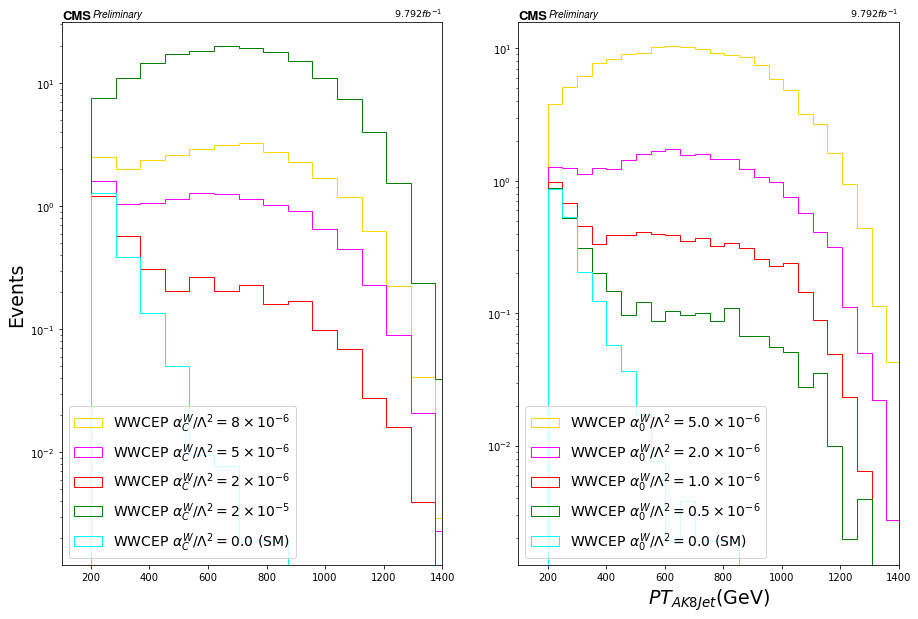

In [18]:
jetAK8_pt_0 = [
DataFrame_SM['jetAK8_pt'],
DataFrame_ANOMALO1['jetAK8_pt'],
DataFrame_ANOMALO2['jetAK8_pt'],
DataFrame_ANOMALO3['jetAK8_pt'],
DataFrame_ANOMALO4['jetAK8_pt'] ]
jetAK8_pt_1 = [
DataFrame_SM['jetAK8_pt'],
DataFrame_ANOMALO5['jetAK8_pt'],
DataFrame_ANOMALO6['jetAK8_pt'],
DataFrame_ANOMALO7['jetAK8_pt'],
DataFrame_ANOMALO8['jetAK8_pt'] ]

plot(jetAK8_pt_0,jetAK8_pt_1,140,140,label_0,label_1,14,100,1400,r'$PT_{AK8Jet}$(GeV)','Events',19,19,'lower left',lista_norm_signal_1,lista_norm_signal_2)

# Grafico Mww --> massa reconstruída do WW

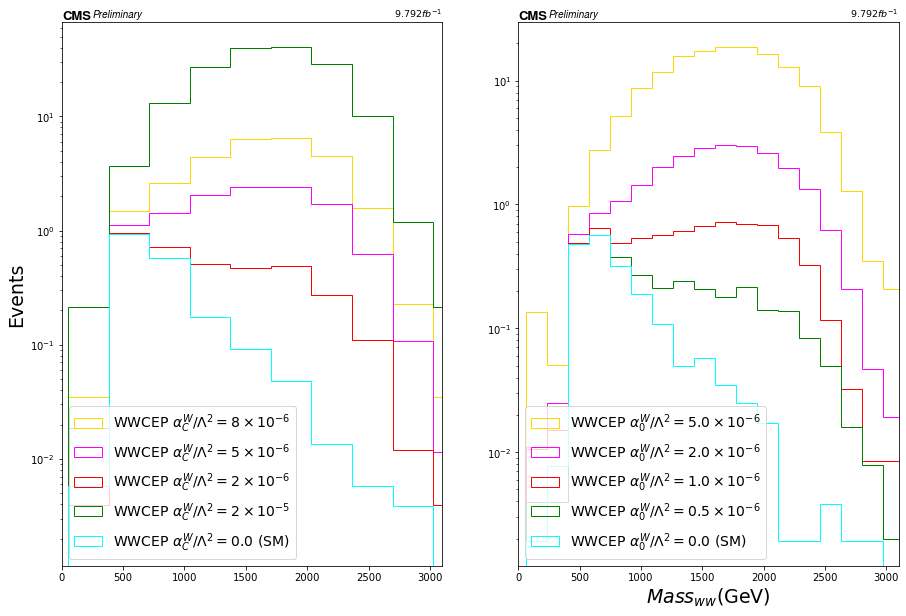

In [19]:
Mww_0 = [ 
DataFrame_SM['Mww'], 
DataFrame_ANOMALO1['Mww'], 
DataFrame_ANOMALO2['Mww'], 
DataFrame_ANOMALO3['Mww'], 
DataFrame_ANOMALO4['Mww']
]
Mww_1 = [ 
DataFrame_SM['Mww'], 
DataFrame_ANOMALO5['Mww'], 
DataFrame_ANOMALO6['Mww'], 
DataFrame_ANOMALO7['Mww'], 
DataFrame_ANOMALO8['Mww']
]


plot(Mww_0,Mww_1,140,140,label_0,label_1,14,0,3100,r'$Mass_{ww}$(GeV)','Events',19,19,'lower left',lista_norm_signal_1,lista_norm_signal_2)

# Grafico Pt do W leptônico

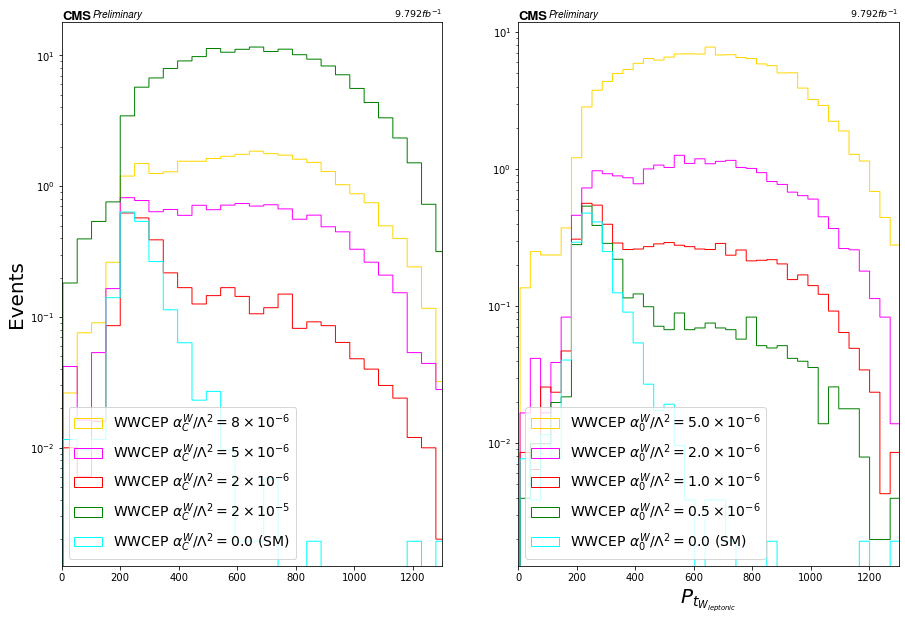

In [20]:
W_lep_Pt_0 = [ 
DataFrame_SM['Pt_W_lep'], 
DataFrame_ANOMALO1['Pt_W_lep'], 
DataFrame_ANOMALO2['Pt_W_lep'], 
DataFrame_ANOMALO3['Pt_W_lep'], 
DataFrame_ANOMALO4['Pt_W_lep']
]
W_lep_Pt_1 = [ 
DataFrame_SM['Pt_W_lep'], 
DataFrame_ANOMALO5['Pt_W_lep'], 
DataFrame_ANOMALO6['Pt_W_lep'], 
DataFrame_ANOMALO7['Pt_W_lep'], 
DataFrame_ANOMALO8['Pt_W_lep']
]


plot(W_lep_Pt_0,W_lep_Pt_1,2000,1000,label_0,label_1,14,0,1300,r'$P_{t_{W_{leptonic}}}$','Events',20,20,'lower left',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico $\Delta \phi (W_{leptônico},W_{hadrônico})$

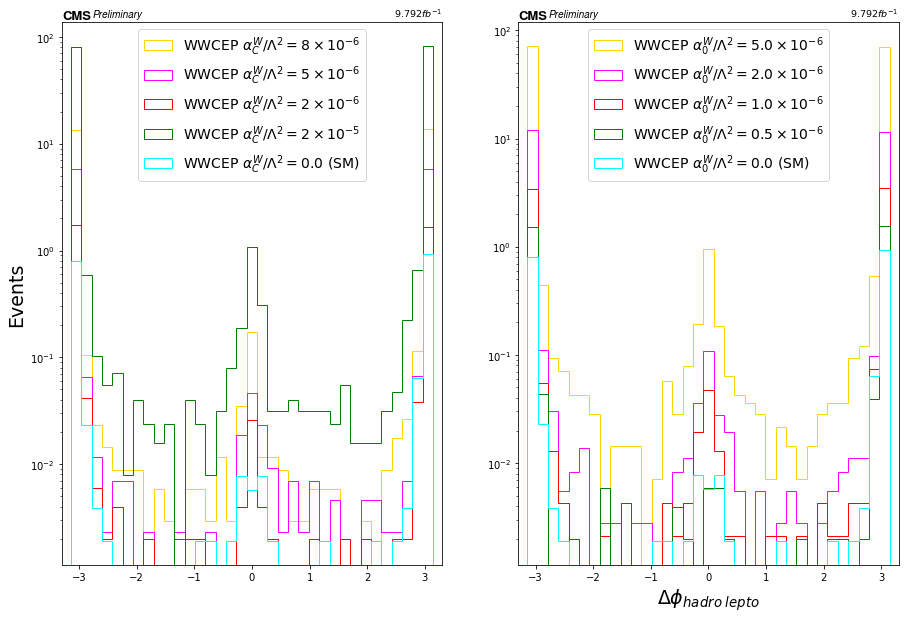

In [21]:
Dphi_jet_lep_0 = [ 
DataFrame_SM['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO1['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO2['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO3['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO4['dPhi_Whad_Wlep']
]
Dphi_jet_lep_1 = [ 
DataFrame_SM['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO5['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO6['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO7['dPhi_Whad_Wlep'], 
DataFrame_ANOMALO8['dPhi_Whad_Wlep']
]

plot(Dphi_jet_lep_0,Dphi_jet_lep_1,35,35,label_0,label_1,14,-3.3,3.3,r'$\Delta \phi_{hadro\;lepto}$','Events',19,19,'upper center',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico $\Delta \phi (Jato,MET)$

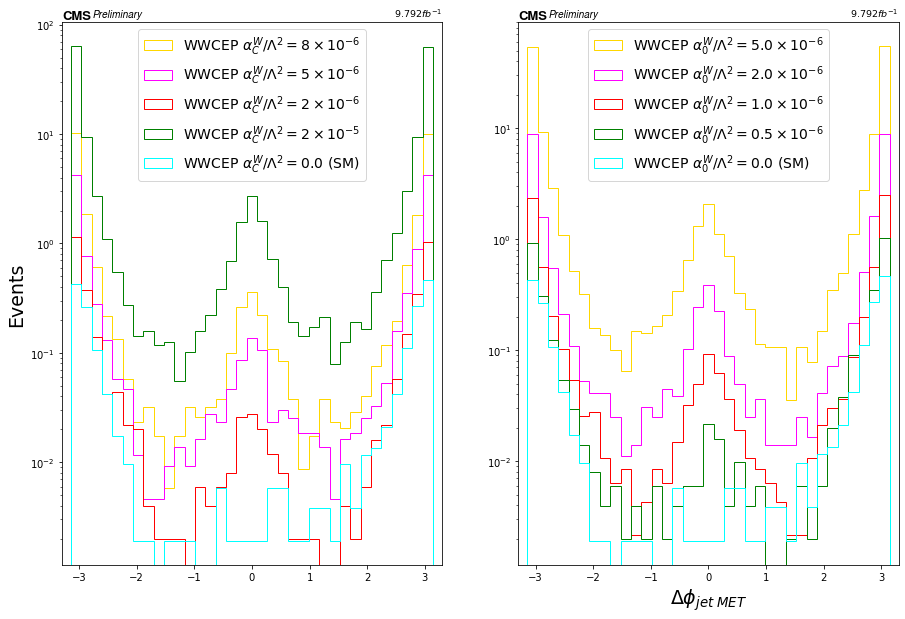

In [22]:
Dphi_jet_MET_0 = [ 
DataFrame_SM['dPhi_jatos_MET'], 
DataFrame_ANOMALO1['dPhi_jatos_MET'], 
DataFrame_ANOMALO2['dPhi_jatos_MET'], 
DataFrame_ANOMALO3['dPhi_jatos_MET'], 
DataFrame_ANOMALO4['dPhi_jatos_MET']
]
Dphi_jet_MET_1 = [ 
DataFrame_SM['dPhi_jatos_MET'], 
DataFrame_ANOMALO5['dPhi_jatos_MET'], 
DataFrame_ANOMALO6['dPhi_jatos_MET'], 
DataFrame_ANOMALO7['dPhi_jatos_MET'], 
DataFrame_ANOMALO8['dPhi_jatos_MET']
]

plot(Dphi_jet_MET_0,Dphi_jet_MET_1,35,35,label_0,label_1,14,-3.3,3.3,r'$\Delta \phi_{jet\;MET}$','Events',19,19,'upper center',lista_norm_signal_1,lista_norm_signal_2)


# Grafico jetAK8 prunedMass

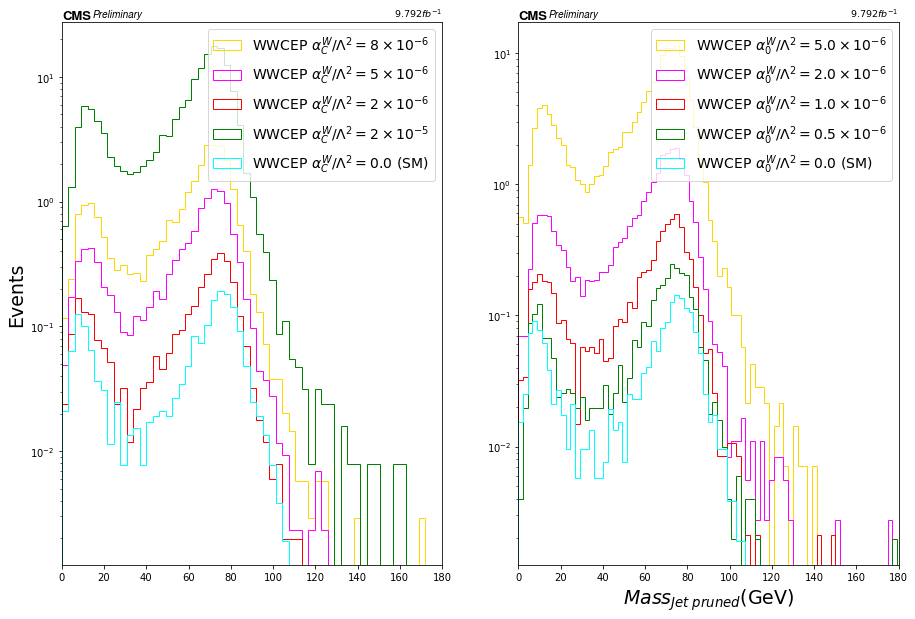

In [23]:
jetAK8_prunedMass_0 = [
DataFrame_SM['jetAK8_prunedMass'],
DataFrame_ANOMALO1['jetAK8_prunedMass'],
DataFrame_ANOMALO2['jetAK8_prunedMass'],
DataFrame_ANOMALO3['jetAK8_prunedMass'],
DataFrame_ANOMALO4['jetAK8_prunedMass'],
]
jetAK8_prunedMass_1 = [
DataFrame_SM['jetAK8_prunedMass'],
DataFrame_ANOMALO5['jetAK8_prunedMass'],
DataFrame_ANOMALO6['jetAK8_prunedMass'],
DataFrame_ANOMALO7['jetAK8_prunedMass'],
DataFrame_ANOMALO8['jetAK8_prunedMass'],
]


plot(jetAK8_prunedMass_0,jetAK8_prunedMass_1,80,80,label_0,label_1,14,0,180,r'$Mass_{Jet\;pruned}$(GeV)','Events',19,19,'best',lista_norm_signal_1,lista_norm_signal_2)


# Grafico jetAK8 tau21

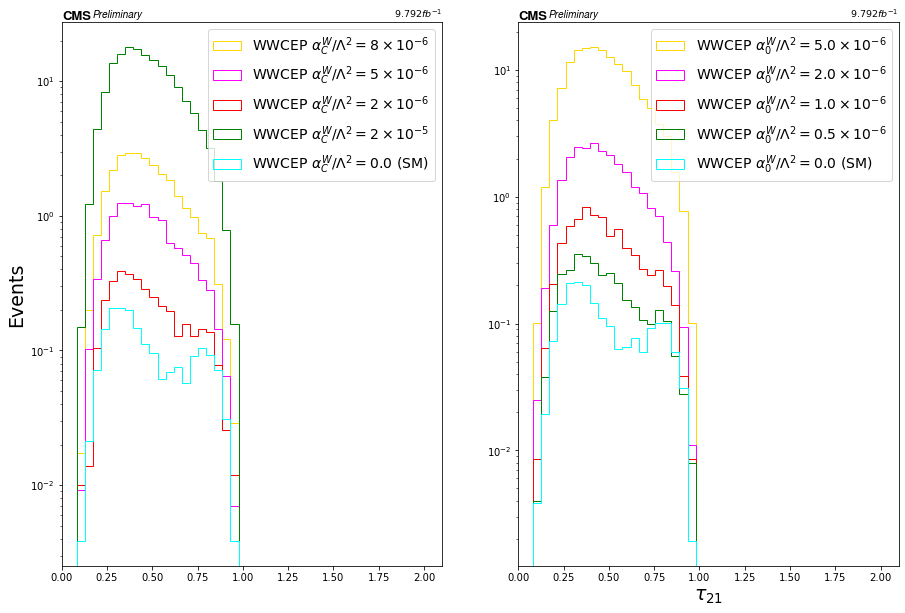

In [24]:
jetAK8_tau21_0 = [
DataFrame_SM['jetAK8_tau21'],
DataFrame_ANOMALO1['jetAK8_tau21'],
DataFrame_ANOMALO2['jetAK8_tau21'],
DataFrame_ANOMALO3['jetAK8_tau21'],
DataFrame_ANOMALO4['jetAK8_tau21'],
]
jetAK8_tau21_1 = [
DataFrame_SM['jetAK8_tau21'],
DataFrame_ANOMALO5['jetAK8_tau21'],
DataFrame_ANOMALO6['jetAK8_tau21'],
DataFrame_ANOMALO7['jetAK8_tau21'],
DataFrame_ANOMALO8['jetAK8_tau21'],
]


plot(jetAK8_tau21_0,jetAK8_tau21_1,20,20,label_0,label_1,14,0,2.1,r'$\tau_{21}$','Events',19,19,'best',lista_norm_signal_1,lista_norm_signal_2)


# Gráfico METPt

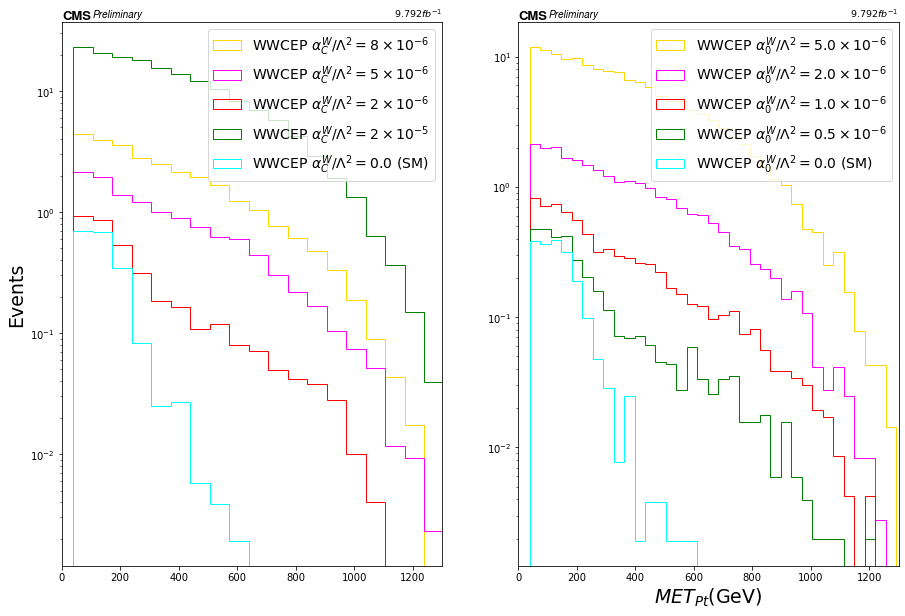

In [25]:
METPt_0 = [
DataFrame_SM['METPt'],
DataFrame_ANOMALO1['METPt'],
DataFrame_ANOMALO2['METPt'],
DataFrame_ANOMALO3['METPt'],
DataFrame_ANOMALO4['METPt'],
]
METPt_1 = [
DataFrame_SM['METPt'],
DataFrame_ANOMALO5['METPt'],
DataFrame_ANOMALO6['METPt'],
DataFrame_ANOMALO7['METPt'],
DataFrame_ANOMALO8['METPt'],
]
plot(METPt_0,METPt_1,180,180,label_0,label_1,14,0,1300,r'$MET_{Pt}$(GeV)','Events',19,19,'upper right',lista_norm_signal_1,lista_norm_signal_2)

# Grafico muon pt

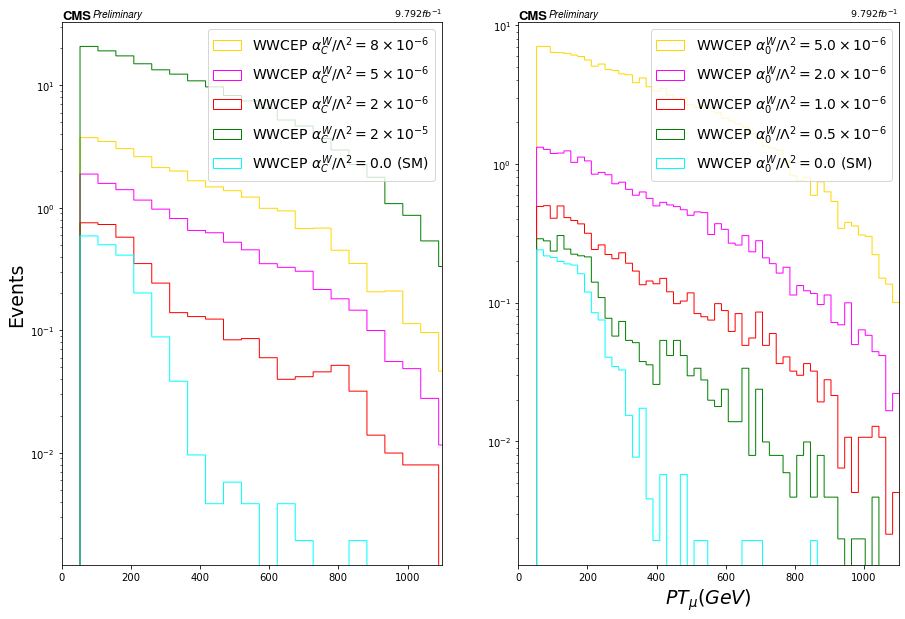

In [26]:
muon_pt_0 = [
DataFrame_SM['muon_pt'],
DataFrame_ANOMALO1['muon_pt'],
DataFrame_ANOMALO2['muon_pt'],
DataFrame_ANOMALO3['muon_pt'],
DataFrame_ANOMALO4['muon_pt'],
]
muon_pt_1 = [
DataFrame_SM['muon_pt'],
DataFrame_ANOMALO5['muon_pt'],
DataFrame_ANOMALO6['muon_pt'],
DataFrame_ANOMALO7['muon_pt'],
DataFrame_ANOMALO8['muon_pt'],
]

plot(muon_pt_0,muon_pt_1,1900,1800,label_0,label_1,14,0,1100,r'$PT_{\mu}(GeV)$','Events',19,19,'upper right',lista_norm_signal_1,lista_norm_signal_2)

# Gráfico Extra Tracks 

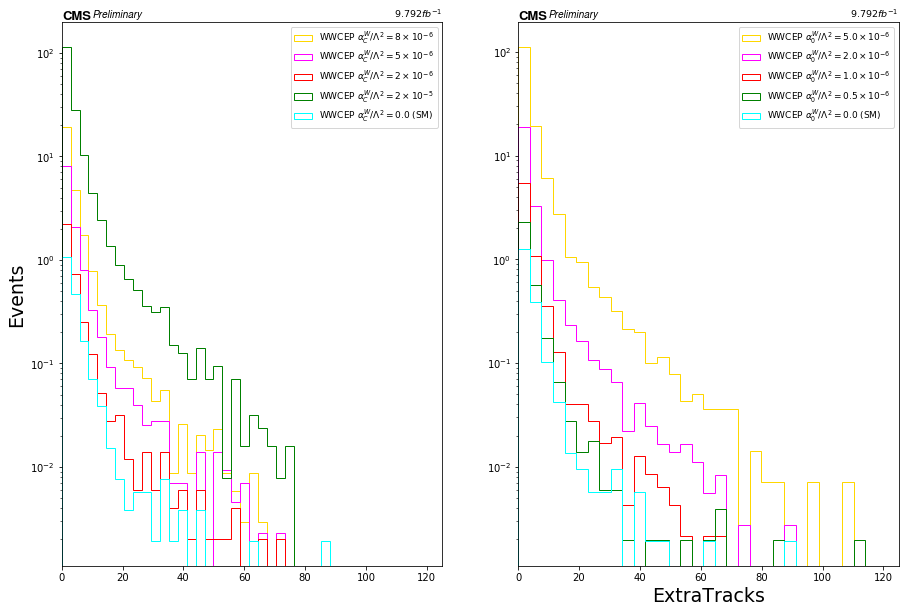

In [27]:
ExtraTracks_0 = [
DataFrame_SM['ExtraTracks'],
DataFrame_ANOMALO1['ExtraTracks'],
DataFrame_ANOMALO2['ExtraTracks'],
DataFrame_ANOMALO3['ExtraTracks'],
DataFrame_ANOMALO4['ExtraTracks'],
]
ExtraTracks_1 = [
DataFrame_SM['ExtraTracks'],
DataFrame_ANOMALO5['ExtraTracks'],
DataFrame_ANOMALO6['ExtraTracks'],
DataFrame_ANOMALO7['ExtraTracks'],
DataFrame_ANOMALO8['ExtraTracks'],
]

plot(ExtraTracks_0,ExtraTracks_1,30,30,label_0,label_1,9,0,125,r'ExtraTracks','Events',19,19,'upper right',lista_norm_signal_1,lista_norm_signal_2)